<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据归一化" data-toc-modified-id="数据归一化-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据归一化</a></span></li><li><span><a href="#回调函数" data-toc-modified-id="回调函数-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>回调函数</a></span></li></ul></div>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


### 数据归一化

In [4]:
#x = (x - μ) / std(方差) 符合均值是零，方差是1的正态分布
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [7]:
#tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10,activation="softmax"))


#relu: y = max（0，x)
#softmax：将向量变成概率分布 x = [x1, x2, x3]
#    y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^X1 + e^x2 + e^x3
#reason for sparse: y->index. y->one)hot->[]
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [8]:
model.layers#查看有多少层

In [9]:
model.summary()#查看模型的架构

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

#第一层[none,784] *w(矩阵)+b（偏置） -> [none,300] w.shape[784,300],b=[300]

### 回调函数

In [10]:
#Tensorborad， earlystopping， modelcheckpoint
logdir = './dnn-callbacks/'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 22s 394us/sample - loss: 2.1668 - accuracy: 0.2115 - val_loss: 1.4199 - val_accuracy: 0.3468
Epoch 2/10
55000/55000 [==============================] - 18s 320us/sample - loss: 0.9400 - accuracy: 0.6316 - val_loss: 0.6028 - val_accuracy: 0.7798
Epoch 3/10
55000/55000 [==============================] - 20s 357us/sample - loss: 0.5416 - accuracy: 0.8060 - val_loss: 0.4435 - val_accuracy: 0.8498
Epoch 4/10
55000/55000 [==============================] - 18s 320us/sample - loss: 0.4496 - accuracy: 0.8443 - val_loss: 0.4554 - val_accuracy: 0.8472
Epoch 5/10
55000/55000 [==============================] - 22s 406us/sample - loss: 0.4039 - accuracy: 0.8587 - val_loss: 0.4184 - val_accuracy: 0.8538
Epoch 6/10
55000/55000 [==============================] - 17s 316us/sample - loss: 0.3752 - accuracy: 0.8701 - val_loss: 0.3815 - val_accuracy: 0.8714
Epoch 7/10
55000/55000 [=====================

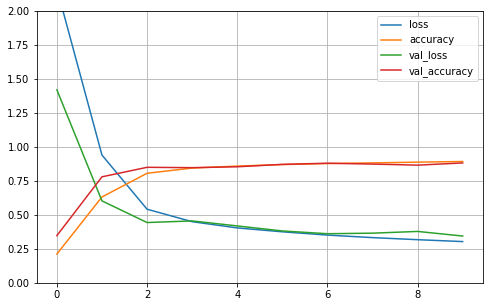

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()
    
plot_learning_curves(history)

#1.参数多，训练不充分，初期目标函数不发生明显变化
#2.梯度消失 ->链式法则 ->复合函数f(g(x))

In [12]:
#指标评估
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3739576518416405, 0.8721]